### Data source and description:

motor_UPDRS - Clinician's motor UPDRS score, linearly interpolated

total_UPDRS - Clinician's total UPDRS score, linearly interpolated

Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP - Several measures of variation in fundamental frequency

Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA - Several measures of variation in amplitude

NHR,HNR - Two measures of ratio of noise to tonal components in the voice

RPDE - A nonlinear dynamical complexity measure

DFA - Signal fractal scaling exponent

PPE - A nonlinear measure of fundamental frequency variation

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score,confusion_matrix,precision_score, recall_score, f1_score)
from sklearn.metrics import roc_curve, roc_auc_score

import joblib
import os

# Load data and pre-process data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [3]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [4]:
data_path = '/Users/linwang/Documents/PredictParkinson/'
fname_rawdata = os.path.join(data_path,'data', 'raw.csv')
df.to_csv(fname_rawdata,index=False)

### Check for missing values

In [4]:
df.isna().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

### Check the composition of the target labels

In [5]:
pd = (df['status']==1).sum()
hc = (df['status']==0).sum()
print(f'number of patients: {pd}')
print(f'number of healthy controls: {hc}')

number of patients: 147
number of healthy controls: 48


### EDA: visualize the distribution of data, separately by target labels

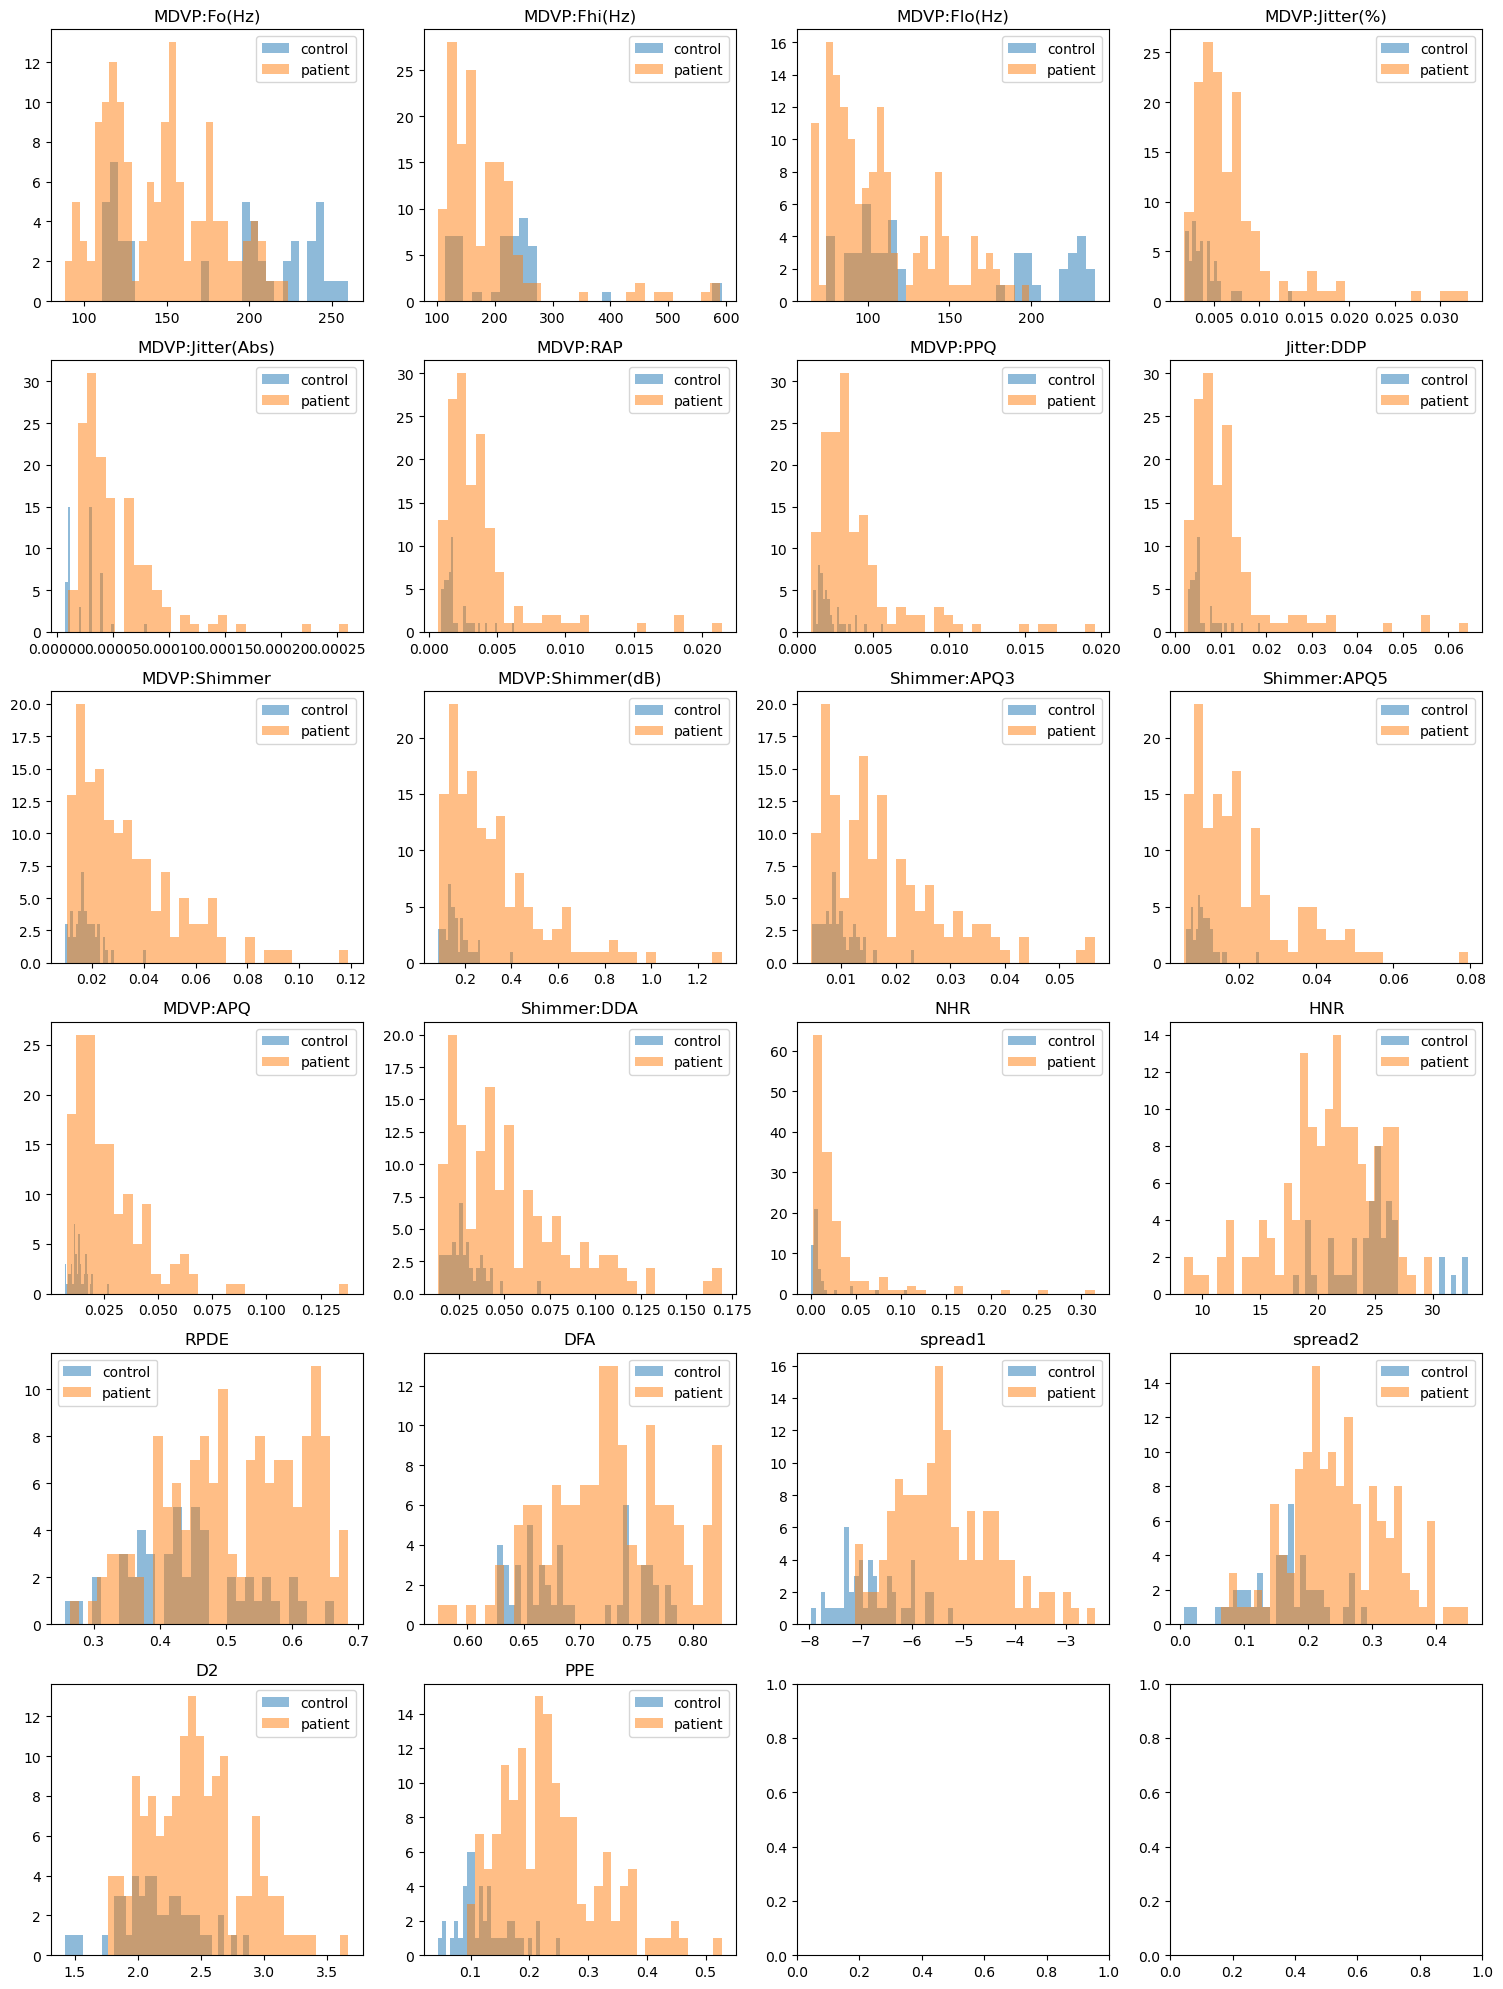

In [90]:
# Separate dependent and independent variables
df_X = df.drop(['name','status'],axis=1)
df_y = df['status']

# Plot distribuctions
labels = {0: 'control', 1: 'patient'} 
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 20))
axes = axes.flatten()
for i, column in enumerate(df_X):
    ax = axes[i]
    for status_value, cond in labels.items():
        status_data = df[df['status'] == status_value]
        ax.hist(status_data[column], bins=30, alpha=0.5, label=cond)
    ax.set_title(column)
    ax.legend()

# Adjust the spacing between subplots and show the plot
plt.tight_layout()
plt.show()

### Check how each feature modulates the target labels

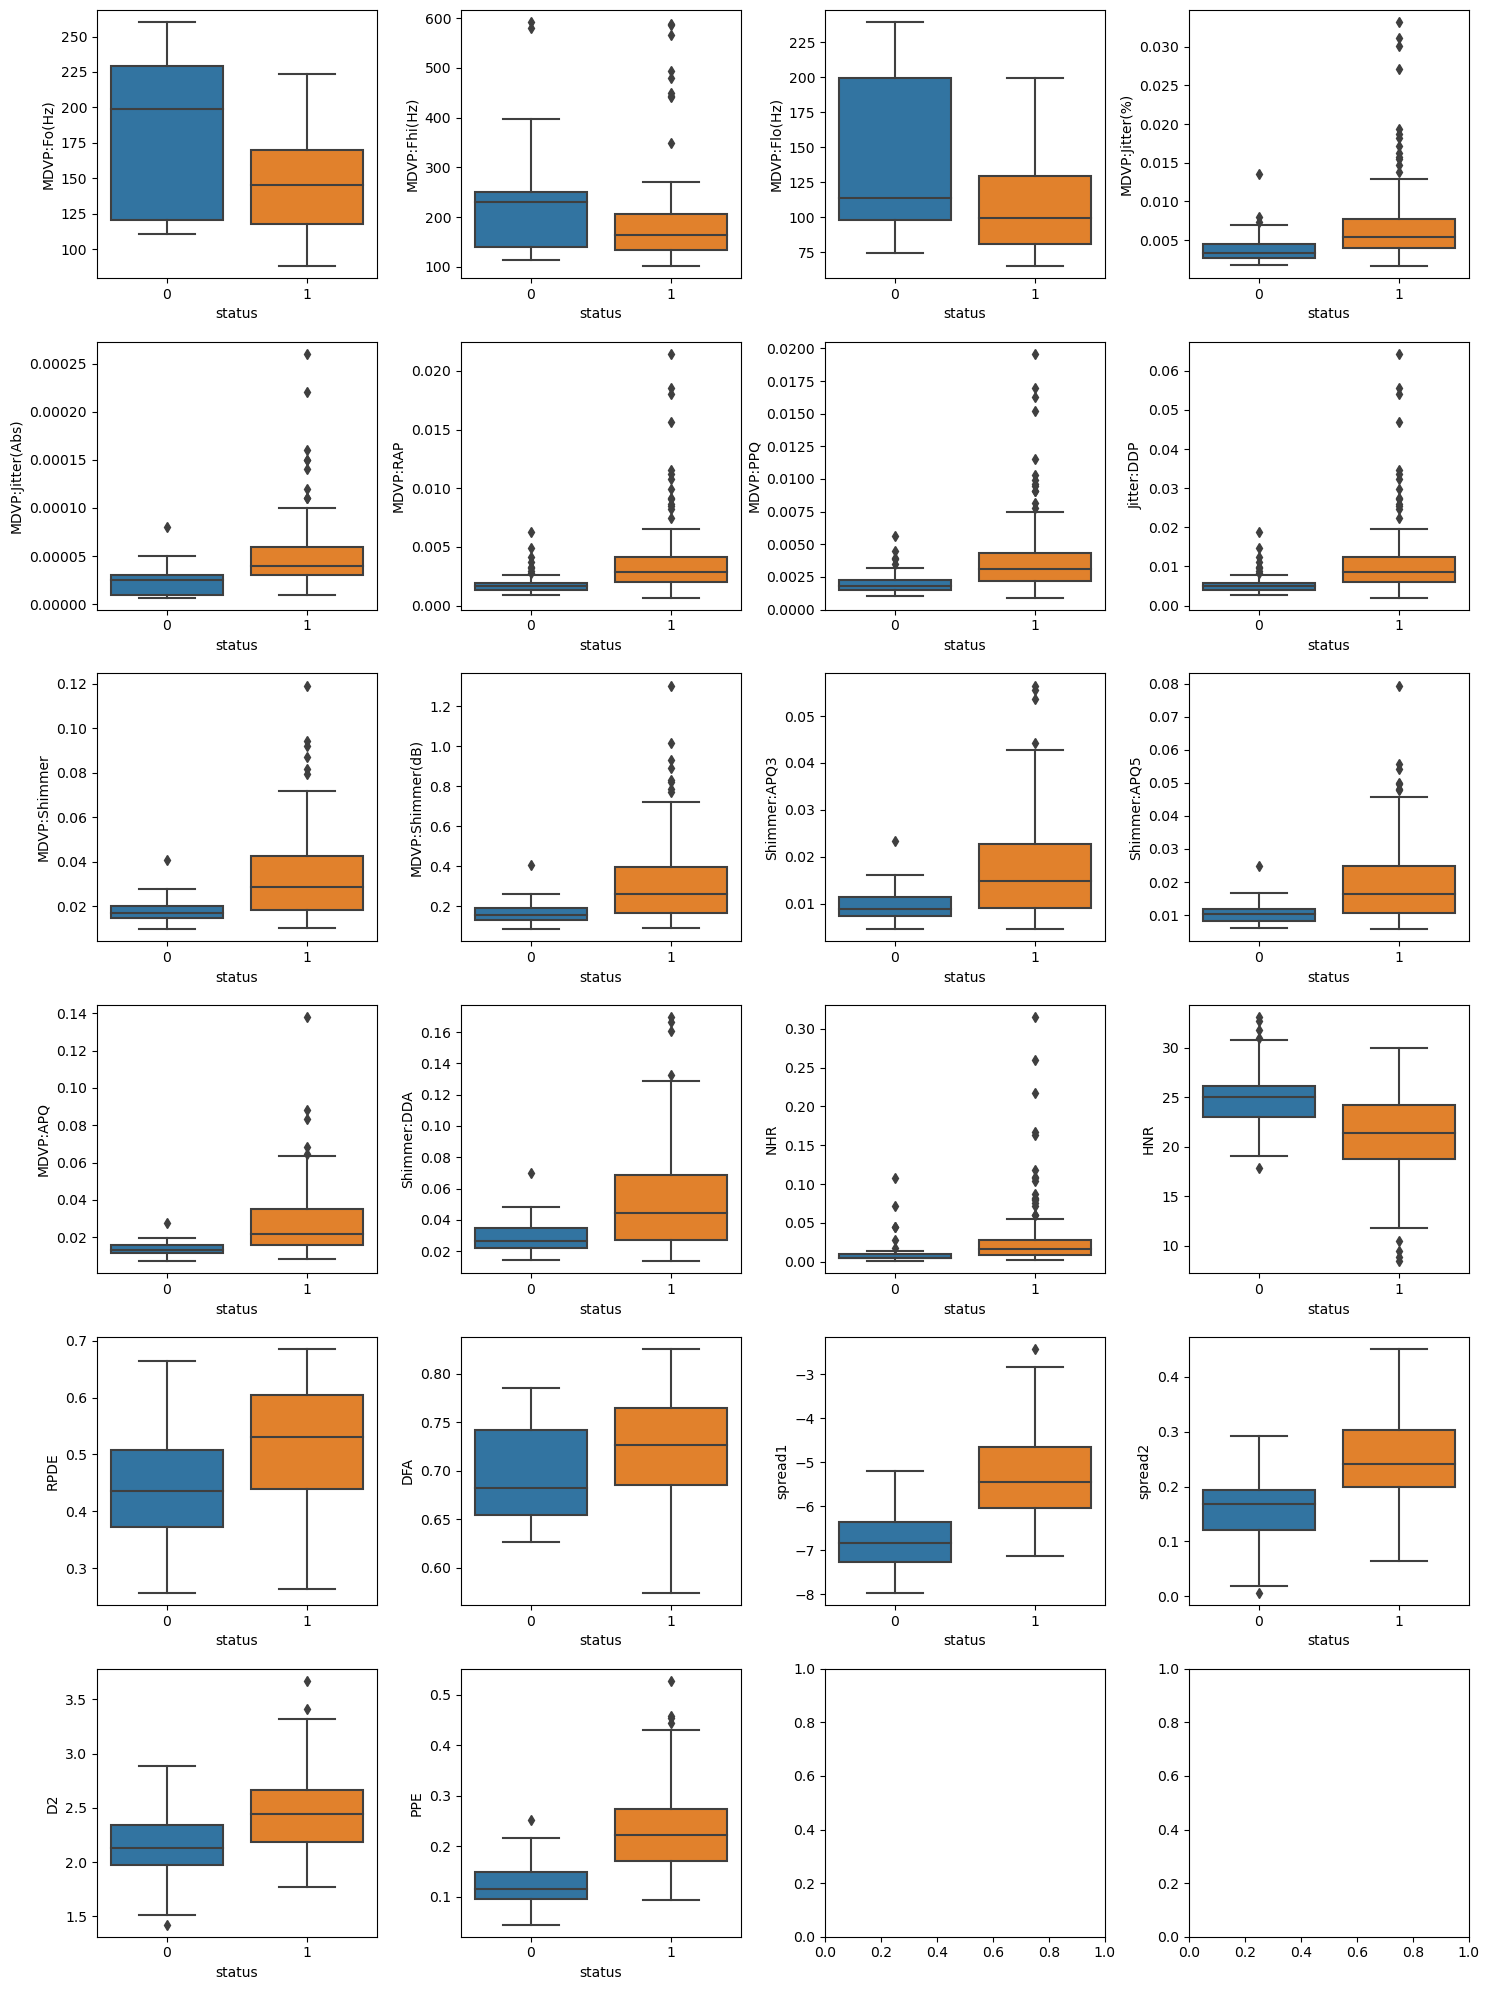

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 20))
axes = axes.flatten()
for i, column in enumerate(df_X):
    ax = axes[i]
    sns.boxplot(x='status', y=column, data=df, ax=ax)
    ax.set_xlabel('status')
    ax.set_ylabel(column)
plt.tight_layout()
plt.show()

### Remove outliers using the interquater range (IQR) method

In [9]:
# Calculate the IQR for each variable
Q1 = df_X.quantile(0.25)
Q3 = df_X.quantile(0.75)
IQR = Q3 - Q1

# Define the acceptable range for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers for each variable
df_X_clean = df_X[~((df_X < lower_bound) | (df_X > upper_bound)).any(axis=1)]

clean_index = df_X_clean.index
df_y_clean = df.loc[clean_index, 'status']
df_y_clean.reset_index(drop=True, inplace=True)

#### Check the number of remaining data

In [10]:
hc = df_y_clean.value_counts()[0]
pd = df_y_clean.value_counts()[1]
print(f'number of patients: {pd}')
print(f'number of healthy controls: {hc}')

number of patients: 114
number of healthy controls: 34


In [5]:
data_path = '/Users/linwang/Documents/PredictParkinson/'
fname_cleandata = os.path.join(data_path,'data', 'clean.csv')
df.to_csv(fname_cleandata,index=False)

### Check relationship between variables

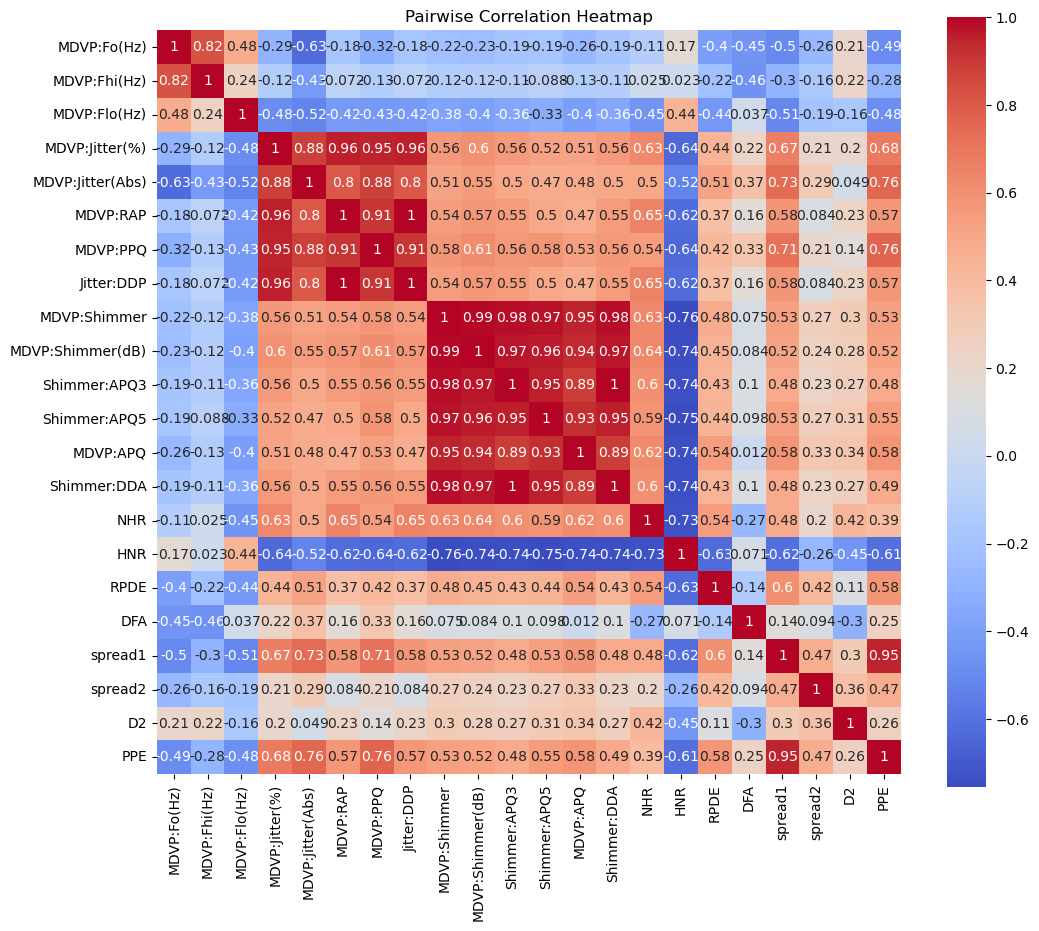

In [11]:
correlation_matrix = df_X_clean.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Pairwise Correlation Heatmap")
plt.show()

#### Use hierarchical clustering to examine the structure of the independent variables

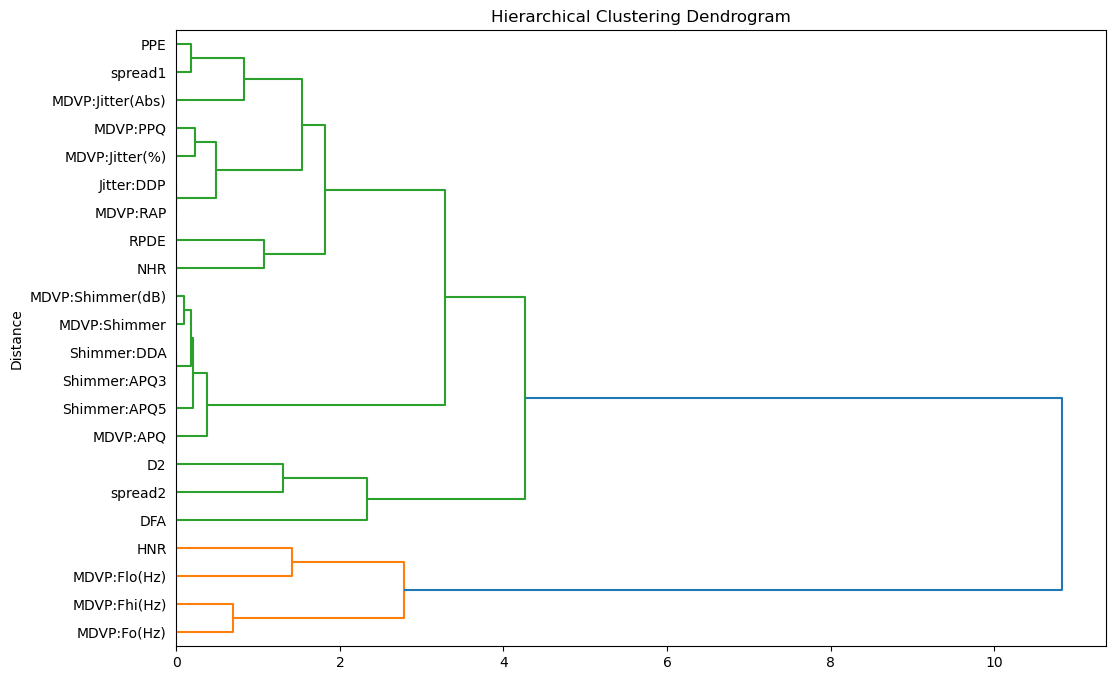

In [12]:
dendrogram = hierarchy.linkage(correlation_matrix, method='ward')
plt.figure(figsize=(12, 8))
dendro_plot = hierarchy.dendrogram(dendrogram, labels=correlation_matrix.columns, leaf_rotation=0, orientation='right')
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Distance")
plt.show()

### Perform PCA for dimensionality reduction and addressing multicollinearity in the data

In [20]:
# Normalize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_X_clean)

# Perform PCA
pca = PCA()
pca.fit(scaled_features)

# Get the components that explain >95% variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Perform PCA with the chosen number of components
pca = PCA(n_components=num_components)
pca_features = pca.fit_transform(scaled_features)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print(f'Number of component selected: {num_components} components')
print(f'Total explained variance: {cumulative_explained_variance[-1]}')

Number of component selected: 9 components
Total explained variance: 0.9637927366422923


# Build machine learning models

## Split the dataset into training and testing sets, normalize them separately to avoid data leakage

In [210]:
# Split pre-processed data
X_train, X_test, y_train, y_test = train_test_split(df_X_clean, df_y_clean, test_size=0.2, stratify=df_y_clean, random_state=123)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic linear regression on PCA components

In [213]:
def model_evaluate(y_test,y_pred,show_metric=True, best_params=None):
    # evaluate model performance
    accuracy = accuracy_score(y_test, np.round(y_pred))
    cf_matrix = confusion_matrix(y_test, np.round(y_pred))
    precision = precision_score(y_test, np.round(y_pred))
    recall = recall_score(y_test, np.round(y_pred))
    f1 = f1_score(y_test, np.round(y_pred))    
    
    if show_metric:
        print("Model performance:")
        print("Accuracy:", accuracy)
        print('------------------------')
        print("Confusion Matrix:\n", cf_matrix)
        print('------------------------')
        print("Precision:", precision)
        print('------------------------')
        print("Recall:", recall)
        print('------------------------')
        print("F1 Score:", f1)
        
        if best_params:
            print('------------------------')
            print("Best parameters:", best_params)
    
    return accuracy, cf_matrix, precision, recall, f1

In [209]:
def model_logregression_pca(num_components,X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate logistic regression model on PCA-processed data'''
    
    # Perform PCA on the normalized data
    pca = PCA(n_components=num_components)
    pca.fit(X_train)

    # Transform the training and testing sets using PCA
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train logistic regression on the transformed training set
    logreg = LogisticRegression()
    logreg.fit(X_train_pca, y_train)

    # Make predictions on the transformed testing set
    y_pred = logreg.predict(X_test_pca)
    
    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric)
    
    return logreg, accuracy, cf_matrix, precision, recall, f1

In [211]:
logreg, accuracy, cf_matrix, precision, recall, f1 = model_logregression_pca(num_components,X_train_scaled,X_test_scaled,y_train,y_test,show_metric=True)

Model performance:
Accuracy: 0.8
------------------------
Confusion Matrix:
 [[ 3  4]
 [ 2 21]]
------------------------
Precision: 0.84
------------------------
Recall: 0.9130434782608695
------------------------
F1 Score: 0.8749999999999999


### Use AUC to identify the optimal threshold

In [67]:
# Perform PCA on the normalized data
pca = PCA(n_components=num_components)
pca.fit(X_train)

# Transform the training and testing sets using PCA
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train logistic regression on the transformed training set
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_pca, y_train)

# Get predicted probabilities for positive class
y_pred_proba = logreg.predict_proba(X_test_pca)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate F1 scores for each threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

# Find the threshold that maximizes the F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
f_max = np.max(f1_scores)
print(f'At optional threshold {optimal_threshold}, the maximal F1-score is {f_max}')

At optional threshold 0.2488817695808491, the maximal F1-score is 0.9019607843137255


/Users/linwang/opt/anaconda3/envs/py4ds/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/linwang/opt/anaconda3/envs/py4ds/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Visualize AUC

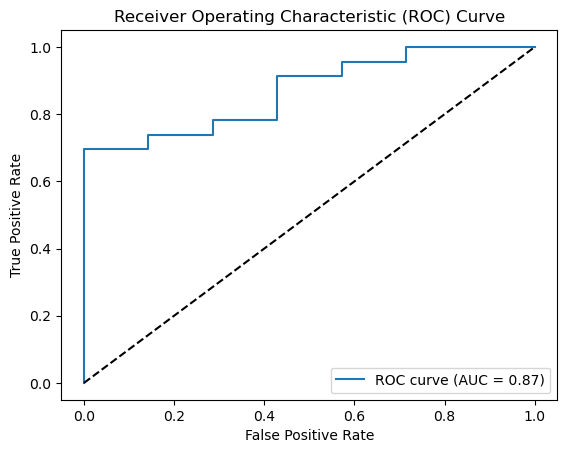

In [68]:
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Regularized logistic linear regression on original data

### Lasso regression: 'l1': Regulate the model using the sum of the absolute values of the coefficients multiplied by a regularization parameter (alpha)

In [177]:
def model_logregression_lasso(X_train, X_test, y_train, y_test,show_metric=True):
    '''Build and evaluate logistic regression model on normalized data using Lasso L1 regularization'''
    
    # Define the parameter grid for grid search
    param_grid = {
        'penalty': ['l1'],  # Change the penalty to l1 for Lasso regression
        'C': [0.1, 1, 10]
    }

    # Create an instance of logistic regression with Lasso penalty
    logreg = LogisticRegression(penalty='l1', solver='liblinear')

    # Create a grid search object
    grid_search = GridSearchCV(logreg, param_grid, cv=5)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Use the best model to make predictions
    y_pred = best_model.predict(X_test)
    
    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [178]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_logregression_lasso(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.8666666666666667
------------------------
Confusion Matrix:
 [[ 3  4]
 [ 0 23]]
------------------------
Precision: 0.8518518518518519
------------------------
Recall: 1.0
------------------------
F1 Score: 0.92
------------------------
Best parameters: {'C': 0.1, 'penalty': 'l1'}


### Ridge regression: 'l2': Regulate the model using the sum of the squared values of the coefficients multiplied by a regularization parameter (alpha)

In [181]:
def model_logregression_ridge(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate logistic regression model on normalized data using ridge L2 regularization'''
    
    # Define the parameter grid for grid search
    param_grid = {
        'penalty': ['l2'],  # Change the penalty to l2
        'C': [0.1, 1, 10]
    }

    # Create an instance of logistic regression
    logreg = LogisticRegression(solver='lbfgs')  # Specify the solver
    grid_search = GridSearchCV(logreg, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Use the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [188]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_logregression_ridge(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.8666666666666667
------------------------
Confusion Matrix:
 [[ 5  2]
 [ 2 21]]
------------------------
Precision: 0.9130434782608695
------------------------
Recall: 0.9130434782608695
------------------------
F1 Score: 0.9130434782608695
------------------------
Best parameters: {'C': 1, 'penalty': 'l2'}


### ElasticNet regression

In [186]:
def model_logregression_elastic(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate logistic regression model on normalized data using elastic regularization'''
    
    param_grid = {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]}
    elastic_net = ElasticNet()
    grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [187]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_logregression_elastic(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.8333333333333334
------------------------
Confusion Matrix:
 [[ 2  5]
 [ 0 23]]
------------------------
Precision: 0.8214285714285714
------------------------
Recall: 1.0
------------------------
F1 Score: 0.9019607843137255
------------------------
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.5}


## K-nearest neighbors

In [189]:
def model_knearest(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate K-nearest neighbors model on normalized data'''
    
    param_grid = {'n_neighbors': [3, 5, 7, 9]}  # Example parameter grid, adjust as needed
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [190]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_knearest(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.9666666666666667
------------------------
Confusion Matrix:
 [[ 6  1]
 [ 0 23]]
------------------------
Precision: 0.9583333333333334
------------------------
Recall: 1.0
------------------------
F1 Score: 0.9787234042553191
------------------------
Best parameters: {'n_neighbors': 3}


## Decision tree

In [191]:
def model_decisiontree(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate decision tree model on normalized data'''
    
    # Define the parameter grid for grid search
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }
    dt = DecisionTreeClassifier()

    # Create a grid search object
    grid_search = GridSearchCV(dt, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)

    return best_model, accuracy, cf_matrix, precision, recall, f1

In [192]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_decisiontree(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.8333333333333334
------------------------
Confusion Matrix:
 [[ 5  2]
 [ 3 20]]
------------------------
Precision: 0.9090909090909091
------------------------
Recall: 0.8695652173913043
------------------------
F1 Score: 0.888888888888889
------------------------
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


### Visualize the decision tree

In [193]:
def plot_decision_tree(model, feature_names):
    '''Plot the decision tree'''
    
    plt.figure(figsize=(10, 8))
    plot_tree(model, filled=True, rounded=True, feature_names=feature_names, class_names=['Healthy', 'Parkinson'])
    plt.show()

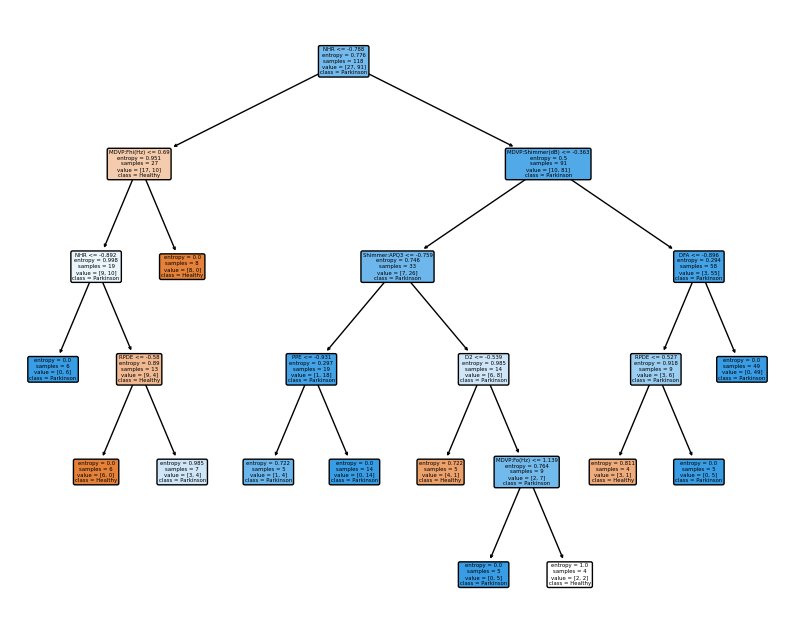

In [121]:
plot_decision_tree(best_model, X_train.columns)

## Random forest

In [194]:
def model_randomforest(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate random forest model on normalized data'''
    
    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}  # Example parameter grid, adjust as needed
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(rf, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [195]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_randomforest(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.9
------------------------
Confusion Matrix:
 [[ 5  2]
 [ 1 22]]
------------------------
Precision: 0.9166666666666666
------------------------
Recall: 0.9565217391304348
------------------------
F1 Score: 0.9361702127659574
------------------------
Best parameters: {'max_depth': 5, 'n_estimators': 300}


## Support Vector Machine (SVM)

In [196]:
def model_svm(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate SVM model on normalized data'''
    
    param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale'],
    'kernel': ['linear', 'rbf']
    }
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    
    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [197]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_svm(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.9666666666666667
------------------------
Confusion Matrix:
 [[ 7  0]
 [ 1 22]]
------------------------
Precision: 1.0
------------------------
Recall: 0.9565217391304348
------------------------
F1 Score: 0.9777777777777777
------------------------
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


## Linear Discriminant Analysis (LDA)

In [198]:
def model_lda(X_train, X_test, y_train, y_test, show_metric=True):
    '''Build and evaluate LDA model on the data'''
    
    param_grid = {}
    lda = LinearDiscriminantAnalysis(solver='svd')
    grid_search = GridSearchCV(lda, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)

    return best_model, accuracy, cf_matrix, precision, recall, f1

In [199]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_lda(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.8
------------------------
Confusion Matrix:
 [[ 5  2]
 [ 4 19]]
------------------------
Precision: 0.9047619047619048
------------------------
Recall: 0.8260869565217391
------------------------
F1 Score: 0.8636363636363636


## Naive Bayes

In [200]:
def model_naivebayes(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate Naive Bayes model on normalized data'''
    
    param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
    }
    nb = GaussianNB()
    grid_search = GridSearchCV(nb, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [201]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_naivebayes(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.7333333333333333
------------------------
Confusion Matrix:
 [[ 6  1]
 [ 7 16]]
------------------------
Precision: 0.9411764705882353
------------------------
Recall: 0.6956521739130435
------------------------
F1 Score: 0.7999999999999999
------------------------
Best parameters: {'var_smoothing': 1e-09}


## Gradient Boosting

In [202]:
def model_gradboosting(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate Gradient Boosting model on normalized data'''
    
    param_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 500, 1000]
    }

    gb = GradientBoostingClassifier()
    grid_search = GridSearchCV(gb, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [203]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_gradboosting(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.9333333333333333
------------------------
Confusion Matrix:
 [[ 6  1]
 [ 1 22]]
------------------------
Precision: 0.9565217391304348
------------------------
Recall: 0.9565217391304348
------------------------
F1 Score: 0.9565217391304348
------------------------
Best parameters: {'learning_rate': 0.1, 'n_estimators': 1000}


## AdaBoost

In [204]:
def model_adaboost(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate Gradient Boosting model on normalized data'''
    
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.1, 0.5, 1.0]
    }
    adaboost = AdaBoostClassifier()
    grid_search = GridSearchCV(adaboost, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [143]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_adaboost(X_train_scaled,X_test_scaled,y_train,y_test)

AdaBoost performance:
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 150}
------------------------
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 150}
------------------------
Accuracy: 0.8333333333333334
------------------------
Confusion Matrix:
 [[ 5  2]
 [ 3 20]]
------------------------
Precision: 0.9090909090909091
------------------------
Recall: 0.8695652173913043
------------------------
F1 Score: 0.888888888888889


## Neural network

In [205]:
def model_nn(X_train,X_test,y_train,y_test,show_metric=True):
    '''Build and evaluate neural network model on normalized data'''

    param_grid = {
    'hidden_layer_sizes': [(20,), (10,10), (10,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [200, 500, 1000],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'early_stopping': [True],
    'n_iter_no_change': [5]  # Number of epochs with no improvement before early stopping
    }

    neural_network = MLPClassifier(random_state=123)
    grid_search = GridSearchCV(neural_network, param_grid, cv=5)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test_scaled)

    # evaluate model performance
    accuracy, cf_matrix, precision, recall, f1 = model_evaluate(y_test,y_pred,show_metric=show_metric,best_params=best_params)
    
    return best_model, accuracy, cf_matrix, precision, recall, f1

In [206]:
best_model, accuracy, cf_matrix, precision, recall, f1 = model_nn(X_train_scaled,X_test_scaled,y_train,y_test)

Model performance:
Accuracy: 0.6666666666666666
------------------------
Confusion Matrix:
 [[ 0  7]
 [ 3 20]]
------------------------
Precision: 0.7407407407407407
------------------------
Recall: 0.8695652173913043
------------------------
F1 Score: 0.7999999999999999
------------------------
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'max_iter': 200, 'n_iter_no_change': 5}


# Run all models and directly compare their performances

## Split the original data

In [207]:
# Split original data
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, stratify=df_y, random_state=123)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Run all models

In [214]:
# Define a dictionary to map model names to their corresponding functions
model_names = {
    'Logistic Regression with PCA': model_logregression_pca,
    'Logistic Regression with Lasso': model_logregression_lasso,
    'Logistic Regression with Ridge': model_logregression_ridge,
    'Logistic Regression with Elastic Net': model_logregression_elastic,
    'k-Nearest Neighbors': model_knearest,
    'Decision Tree': model_decisiontree,
    'Random Forest': model_randomforest,
    'Support Vector Machine': model_svm,
    'Linear Discriminant Analysis': model_lda,
    'Naive Bayes': model_naivebayes,
    'Gradient Boosting': model_gradboosting,
    'AdaBoost': model_adaboost,
    'Neural Network': model_nn
}

# Run all models
results = []
for model_name, model_func in model_names.items():
    if model_name == 'Logistic Regression with PCA':
        best_model, accuracy, _, precision, recall, f1 = model_func(num_components, X_train_scaled, X_test_scaled, y_train, y_test, show_metric=False)
    else:
        best_model, accuracy, _, precision, recall, f1 = model_func(X_train_scaled, X_test_scaled, y_train, y_test, show_metric=False)
    results.append((model_name, best_model, accuracy, precision, recall, f1))

## Get the top N models based on each evaluation metric

In [215]:
# Sort the results based on each evaluation metric
sorted_results_accuracy = sorted(results, key=lambda x: x[2], reverse=True)
sorted_results_precision = sorted(results, key=lambda x: x[3], reverse=True)
sorted_results_recall = sorted(results, key=lambda x: x[4], reverse=True)
sorted_results_f1 = sorted(results, key=lambda x: x[5], reverse=True)

# Get the top N model for each evaluation metric
n=1
topn_accuracy = sorted_results_accuracy[:n]
topn_precision = sorted_results_precision[:n]
topn_recall = sorted_results_recall[:n]
topn_f1 = sorted_results_f1[:n]

# Print the top 2 models for each evaluation metric
print(f"Top {n} models based on accuracy:")
for model in topn_accuracy:
    print("Model:", model[0])
    print("Accuracy:", model[2])
    print("Precision:", model[3])
    print("Recall:", model[4])
    print("F1 Score:", model[5])
    print("------------------------")

print(f"Top {n} models based on precision:")
for model in topn_precision:
    print("Model:", model[0])
    print("Accuracy:", model[2])
    print("Precision:", model[3])
    print("Recall:", model[4])
    print("F1 Score:", model[5])
    print("------------------------")

print(f"Top {n} models based on recall:")
for model in topn_recall:
    print("Model:", model[0])
    print("Accuracy:", model[2])
    print("Precision:", model[3])
    print("Recall:", model[4])
    print("F1 Score:", model[5])
    print("------------------------")

print(f"Top {n} models based on F1 Score:")
for model in topn_f1:
    print("Model:", model[0])
    print("Accuracy:", model[2])
    print("Precision:", model[3])
    print("Recall:", model[4])
    print("F1 Score:", model[5])
    print("------------------------")

Top 1 models based on accuracy:
Model: k-Nearest Neighbors
Accuracy: 0.9666666666666667
Precision: 0.9583333333333334
Recall: 1.0
F1 Score: 0.9787234042553191
------------------------
Top 1 models based on precision:
Model: Support Vector Machine
Accuracy: 0.9666666666666667
Precision: 1.0
Recall: 0.9565217391304348
F1 Score: 0.9777777777777777
------------------------
Top 1 models based on recall:
Model: Logistic Regression with Lasso
Accuracy: 0.8666666666666667
Precision: 0.8518518518518519
Recall: 1.0
F1 Score: 0.92
------------------------
Top 1 models based on F1 Score:
Model: k-Nearest Neighbors
Accuracy: 0.9666666666666667
Precision: 0.9583333333333334
Recall: 1.0
F1 Score: 0.9787234042553191
------------------------


## Save the best model

In [228]:
# Extract the best model
best_model = topn_accuracy[0][1]
best_model_name = topn_accuracy[0][0]

data_path = '/Users/linwang/Documents/PredictParkinson/'
fname_model = os.path.join(data_path,'models', 'best_model' + best_model_name.replace(' ','-') + '.pkl')
fname_scaler = os.path.join(data_path,'models', 'scaler.pkl')

# Save the best model
joblib.dump(best_model, fname_model)

# Save the normalization scaler
joblib.dump(scaler, fname_scaler)

['/Users/linwang/Documents/PredictParkinson/models/scaler.pkl']

# Test on new data

In [229]:
# Load the saved model
best_model = joblib.load(fname_model)

# Load normalization scaler
scaler = joblib.load(fname_scaler)

# Generate fake data with the same shape as X_test
num_samples = 2
num_features = X_test.shape[1]
fake_data = np.random.rand(num_samples, num_features)

# Normalize the fake data using the scaler
fake_data_scaled = scaler.transform(fake_data)

# Make predictions on the fake data using the best_model
fake_predictions = best_model.predict(fake_data_scaled)
print(fake_predictions)

[1 1]


/Users/linwang/opt/anaconda3/envs/py4ds/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
